In this notebook we will use the nn class **Sequential** to model a CNN

We will use the single target network

# Import

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.model_selection import KFold

from tqdm import tqdm

import load_script
from params import *
from custom_layers import *
from training import *
from networks import *

from utilities import *
from parse_dataset import *

In [2]:
# %load_ext autoreload
# %autoreload 2

# Loading the dataset

In [3]:
folder=Dataset(base_directory='/home/stefano/',dataset='eeg')

Reading data from /home/stefano/EEG//
Reading data from /home/stefano/EEG//stored//
Reading data from /home/stefano/EEG//__pycache__//
Reading data from /home/stefano/EEG//data//
Reading data from /home/stefano/EEG//stefano//
Reading data from /home/stefano/EEG//stefano//__pycache__//
Reading data from /home/stefano/EEG//stefano//notebook//


In [4]:
# train_dataset,train_target=load_script.load_dataset_1000hz(train=True)

In [5]:
# test_dataset,test_target=load_script.load_dataset_1000hz(train=False)

In [6]:
train_dataset,train_target=load_script.load_dataset(train=True)

In [7]:
test_dataset,test_target=load_script.load_dataset(train=False)

# Normalization

In [8]:
train_dataset.shape

torch.Size([316, 28, 50])

In [9]:
test_dataset.shape

torch.Size([100, 28, 50])

In [10]:
mean=train_dataset.mean(0).mean(1).view(1,28,1)
std=train_dataset.std(2).mean(0).view(1,28,1)

In [11]:
train_dataset=(train_dataset-mean)/std
test_dataset=(test_dataset-mean)/std

# Defining the network

### Simple Network

# Training

  2%|▏         | 7/300 [00:00<00:04, 69.45it/s]

Dropout 0
42.0
Network:

[28, 28, 3, 1, 0, True]
[28, 28, 3, 1, 0, True]
[28, 28, 3, 1, 0, True]
[28, 28, 3, 1, 0, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 300/300 [00:08<00:00, 33.65it/s]


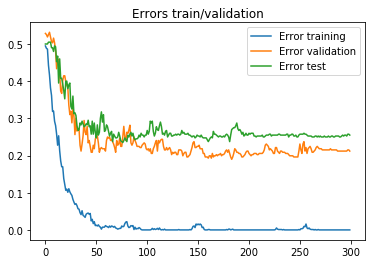

  1%|▏         | 4/300 [00:00<00:07, 39.36it/s]

Performance train: 0.00106891701828
Performance validation: 0.21253164557
Performance test: 0.2535
Dropout 0.1
42.0
Network:

[28, 28, 3, 1, 0.1, True]
[28, 28, 3, 1, 0.1, True]
[28, 28, 3, 1, 0.1, True]
[28, 28, 3, 1, 0.1, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 300/300 [00:10<00:00, 29.81it/s]


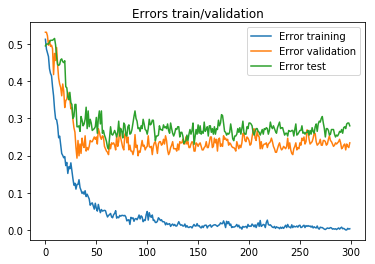

  1%|▏         | 4/300 [00:00<00:07, 38.35it/s]

Performance train: 0.0063994374121
Performance validation: 0.231139240506
Performance test: 0.2691
Dropout 0.2
42.0
Network:

[28, 28, 3, 1, 0.2, True]
[28, 28, 3, 1, 0.2, True]
[28, 28, 3, 1, 0.2, True]
[28, 28, 3, 1, 0.2, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 300/300 [00:12<00:00, 23.48it/s]


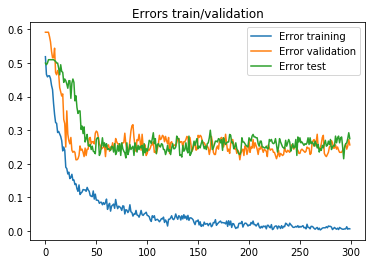

  1%|▏         | 4/300 [00:00<00:07, 37.50it/s]

Performance train: 0.0108579465541
Performance validation: 0.244599156118
Performance test: 0.259633333333
Dropout 0.3
42.0
Network:

[28, 28, 3, 1, 0.3, True]
[28, 28, 3, 1, 0.3, True]
[28, 28, 3, 1, 0.3, True]
[28, 28, 3, 1, 0.3, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 300/300 [00:10<00:00, 28.25it/s]


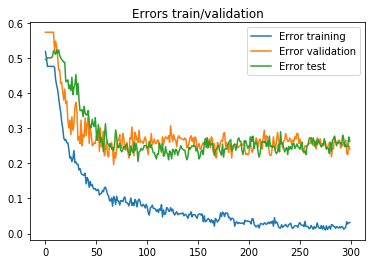

  1%|▏         | 4/300 [00:00<00:07, 38.91it/s]

Performance train: 0.0212798874824
Performance validation: 0.256666666667
Performance test: 0.2519
Dropout 0.4
42.0
Network:

[28, 28, 3, 1, 0.4, True]
[28, 28, 3, 1, 0.4, True]
[28, 28, 3, 1, 0.4, True]
[28, 28, 3, 1, 0.4, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 300/300 [00:10<00:00, 23.39it/s]


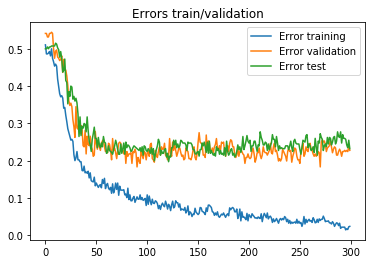

  1%|▏         | 4/300 [00:00<00:09, 30.56it/s]

Performance train: 0.0355414908579
Performance validation: 0.224767932489
Performance test: 0.2466
Dropout 0.5
42.0
Network:

[28, 28, 3, 1, 0.5, True]
[28, 28, 3, 1, 0.5, True]
[28, 28, 3, 1, 0.5, True]
[28, 28, 3, 1, 0.5, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 300/300 [00:10<00:00, 29.39it/s]


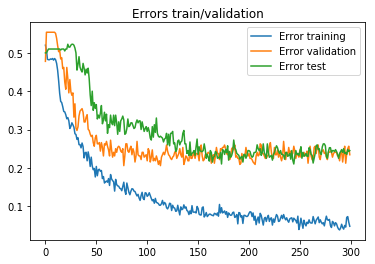

  1%|▏         | 4/300 [00:00<00:08, 34.43it/s]

Performance train: 0.0593389592124
Performance validation: 0.237341772152
Performance test: 0.239833333333
Dropout 0.6
42.0
Network:

[28, 28, 3, 1, 0.6, True]
[28, 28, 3, 1, 0.6, True]
[28, 28, 3, 1, 0.6, True]
[28, 28, 3, 1, 0.6, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 300/300 [00:11<00:00, 27.00it/s]


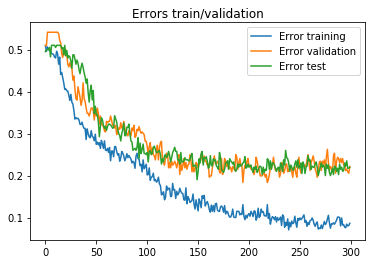

  1%|▏         | 4/300 [00:00<00:08, 35.55it/s]

Performance train: 0.0889451476793
Performance validation: 0.222995780591
Performance test: 0.221133333333
Dropout 0.7
42.0
Network:

[28, 28, 3, 1, 0.7, True]
[28, 28, 3, 1, 0.7, True]
[28, 28, 3, 1, 0.7, True]
[28, 28, 3, 1, 0.7, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 300/300 [00:05<00:00, 52.88it/s]


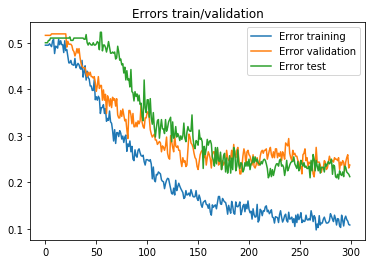

  2%|▏         | 7/300 [00:00<00:04, 65.88it/s]

Performance train: 0.120225035162
Performance validation: 0.248818565401
Performance test: 0.232633333333
Dropout 0.8
42.0
Network:

[28, 28, 3, 1, 0.8, True]
[28, 28, 3, 1, 0.8, True]
[28, 28, 3, 1, 0.8, True]
[28, 28, 3, 1, 0.8, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 300/300 [00:05<00:00, 52.90it/s]


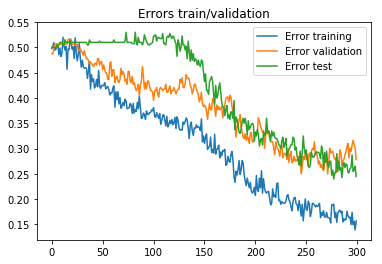

  2%|▏         | 7/300 [00:00<00:04, 68.46it/s]

Performance train: 0.17805907173
Performance validation: 0.284219409283
Performance test: 0.2809
Dropout 0.9
42.0
Network:

[28, 28, 3, 1, 0.9, True]
[28, 28, 3, 1, 0.9, True]
[28, 28, 3, 1, 0.9, True]
[28, 28, 3, 1, 0.9, True]
[1176, 200]
[200, 2]

Repetition 0


100%|██████████| 300/300 [00:07<00:00, 38.77it/s]


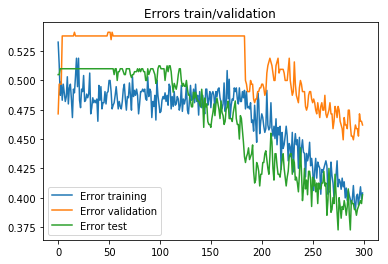

Performance train: 0.420843881857
Performance validation: 0.476455696203
Performance test: 0.405533333333


In [20]:
dropout_values=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results=[]
for dropout in dropout_values:
    print('Dropout',dropout)
    cv=CrossValidation(k=4,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target,cuda=True)
    
    net_type=FourCNNLayers
    optimizer_type=optim.Adam
    criterion_type=nn.CrossEntropyLoss
    network_params=NetworkParams(conv_filters=[28,28,28],conv_kernels=[3,3,3],
                                 linear_filters=[200,2],
                                 dropout_rate=dropout,batch_norm=True,conv1D=True)
    optimizer_params=OptimizerParams()
    train_params=TrainParams(max_epoch=300,mini_batch_size=79)


    params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
                  optimizer_params=optimizer_params,train_params=train_params,cuda=True)

    cv(params,repetitions=1,cross_validation=True,repetitions_test=4)
    results.append(cv.result)

In [21]:
params.network

FourCNNLayers(
  (sequential): Sequential(
    (0): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): Dropout(p=0.9)
    (4): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (6): ReLU()
    (7): Dropout(p=0.9)
    (8): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (10): ReLU()
    (11): Dropout(p=0.9)
    (12): Conv1d(28, 28, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(28, eps=1e-05, momentum=0.1, affine=True)
    (14): ReLU()
    (15): Dropout(p=0.9)
    (16): Flatten(
    )
    (17): Linear(in_features=1176, out_features=200, bias=True)
    (18): ReLU()
    (19): Linear(in_features=200, out_features=2, bias=True)
  )
)

In [22]:
save=True
if save:
    file_name=folder.stored+'four_layers'
    write_pickle(results,file_name)

In [ ]:
cv=CrossValidation(k=2,train_dataset=train_dataset,test_dataset=test_dataset,
                   train_target=train_target,test_target=test_target)

net_type=ThreeLayers2D
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(conv_filters=[28,28,28],conv_kernels=[(3,1),(5,3),(3,3)],
                             linear_filters=[200,2],
                             dropout_rate=0,batch_norm=False,conv1D=False)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=100,mini_batch_size=79)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,)

cv(params)

In [ ]:
net_type=ThreeLayers
optimizer_type=optim.Adam
criterion_type=nn.CrossEntropyLoss
network_params=NetworkParams(linear_filters=[200,2],dropout_rate=0)
optimizer_params=OptimizerParams()
train_params=TrainParams(max_epoch=100)


params=Params(net_type,optimizer_type,criterion_type,network_params=network_params,
              optimizer_params=optimizer_params,train_params=train_params,)

train=Train(train_dataset=train_dataset,test_dataset=test_dataset,
            train_target=train_target,test_target=test_target)
train(params)